In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import numpy as np
from tools.model import Unet

In [ ]:
model = Unet().to('cuda')

In [ ]:
checkpoint = torch.load('/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_notebooks/cnn/model_piunet_opt_b3_elr_bm/model_10000.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [ ]:
b_norm = 2500

In [ ]:
inputs = np.load('data/inputs_11158.npy')*b_norm
outputs = np.load('data/outputs_11158.npy')*b_norm

In [ ]:
# inputs = np.flip(inputs, axis=0)
# outputs = np.flip(outputs, axis=0)

In [ ]:
np.max(inputs, axis=(1, 2, 3, 4)).shape

(66,)

In [ ]:
inputs_max = np.max(np.abs(inputs), axis=(1, 2, 3, 4))[:, None, None, None, None]

In [ ]:
inputs.shape

(66, 3, 513, 257, 1)

In [ ]:
inputs_max.shape

(66, 1, 1, 1, 1)

In [ ]:
# -1 ~ 1
inputs_norm = inputs / inputs_max

In [ ]:
inputs_norm.shape

(66, 3, 513, 257, 1)

In [ ]:
model_input = torch.Tensor(inputs_norm).to('cuda')
labels = outputs

model_input.shape, labels.shape

(torch.Size([66, 3, 513, 257, 1]), (66, 3, 513, 257, 50))

In [ ]:
model_input = torch.permute(model_input, (0, 4, 3, 2, 1))
model_input.shape

torch.Size([66, 1, 257, 513, 3])

In [ ]:
N = model_input.shape[0]
N

66

In [ ]:
bs = []
for i in range(N):
    model_input[i].shape
    b = model(model_input[i][None, ...])
    b = b.cpu().detach().numpy().transpose(0, 3, 2, 1, 4)
    bs.append(b)
bs = np.array(bs)
bs.shape

(66, 1, 513, 257, 50, 3)

In [ ]:
bs[:, 0, ...].shape

(66, 513, 257, 50, 3)

In [ ]:
inputs_max.shape

(66, 1, 1, 1, 1)

In [ ]:
# restore
bs = bs[:, 0, ...]*inputs_max
bs.shape

(66, 513, 257, 50, 3)

In [ ]:
b2 = (bs**2).sum(-1).sum((1, 2, 3))
b2.shape

(66,)

In [ ]:
b2[0]

74008970000.0

In [ ]:
labels.shape

(66, 3, 513, 257, 50)

In [ ]:
B2 = ((labels)**2).sum(1).sum((1, 2, 3))
B2.shape

(66,)

In [ ]:
B2[0]

80785965000.0

In [ ]:
eps = b2/B2 
eps[0]

0.9161117

In [ ]:
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

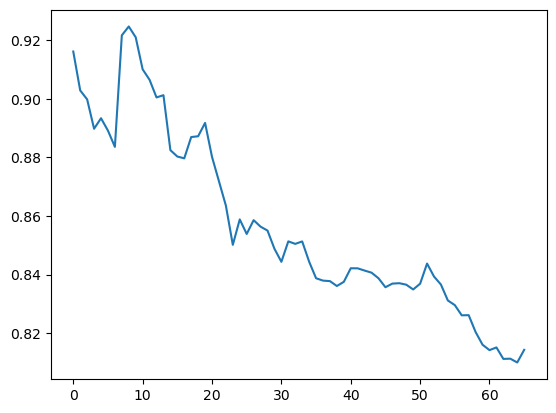

In [ ]:
plt.plot(eps)

[<matplotlib.lines.Line2D>]

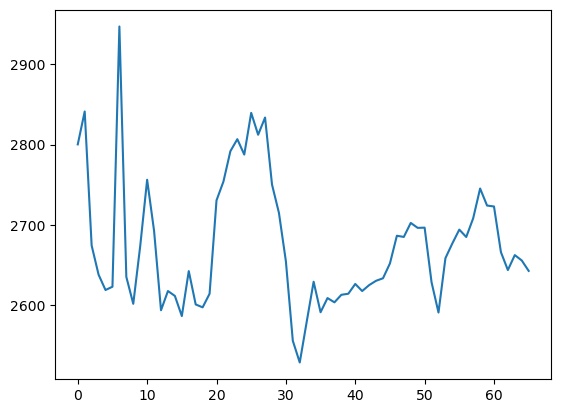

In [ ]:
plt.plot(inputs_max.squeeze())

In [ ]:
outputs_pot = np.load('data/outputs_pot_11158.npy')*b_norm

In [ ]:
outputs_pot.shape

(66, 3, 513, 257, 50)

In [ ]:
Bpot2 = ((outputs_pot)**2).sum(1).sum((1, 2, 3))
Bpot2.shape

(66,)

In [ ]:
Bpot2[0]

66449002000.0

<matplotlib.legend.Legend>

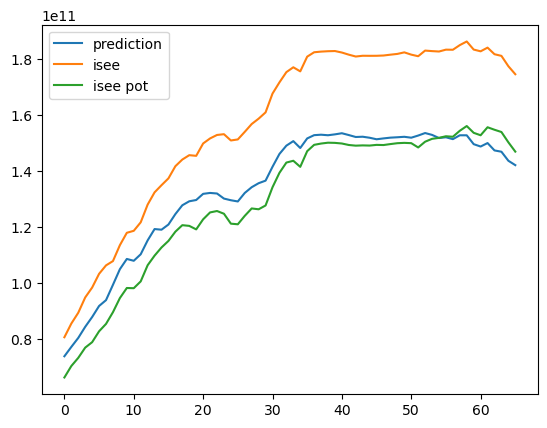

In [ ]:
plt.plot(b2, label='prediction')
plt.plot(B2, label='isee')
plt.plot(Bpot2, label='isee pot')
plt.legend()

<matplotlib.legend.Legend>

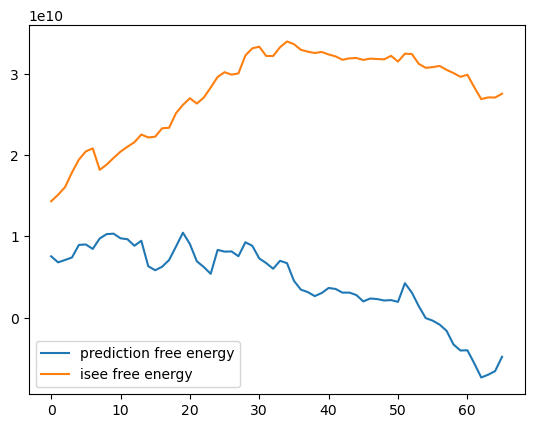

In [ ]:
plt.plot(b2-Bpot2, label='prediction free energy')
plt.plot(B2-Bpot2, label='isee free energy')
plt.legend()

In [ ]:
b = bs[0]
B = labels[0].transpose(1, 2, 3, 0)
b.shape, B.shape

((513, 257, 50, 3), (513, 257, 50, 3))

In [ ]:
from tools.ploting import plot_overview
from tools.metric import evaluate
from tools.metric_another import metrics

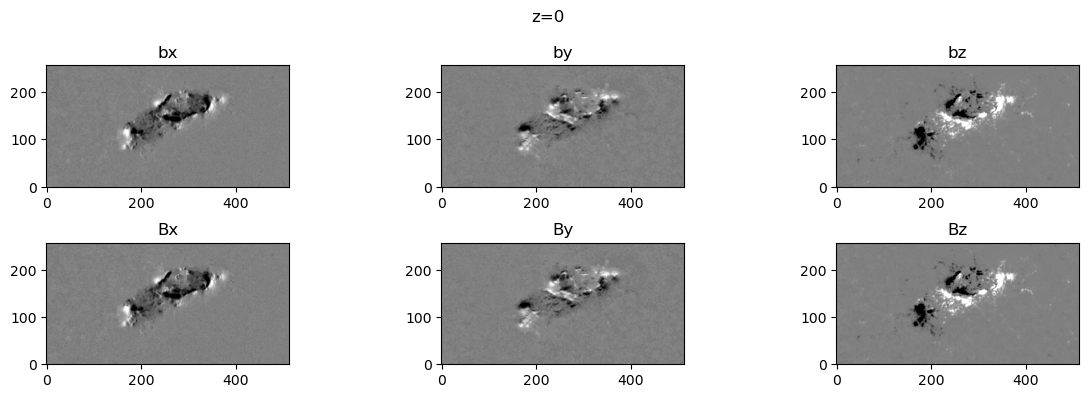

In [ ]:
plot_overview(b, B, z=0, b_norm=1000)

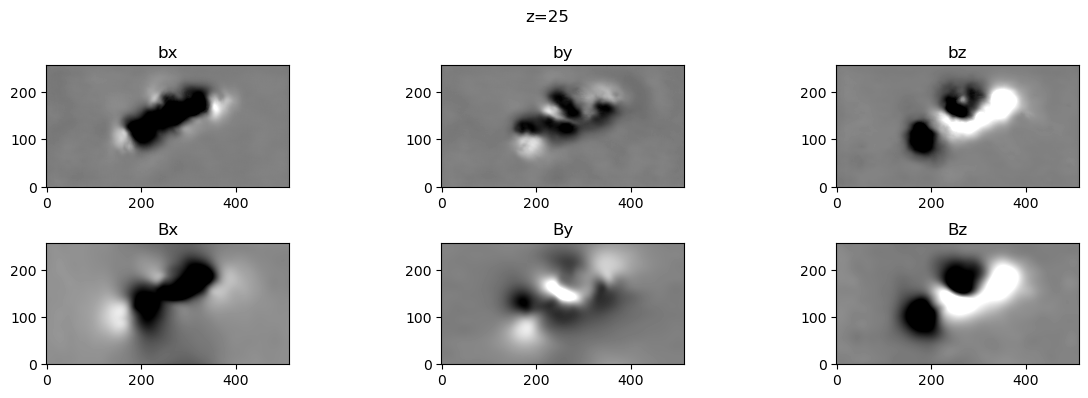

In [ ]:
plot_overview(b, B, z=25, b_norm=100)

In [ ]:
evaluate(b, B)

/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:58: RuntimeWarning: invalid value encountered in divide
  result['C_cs'] = 1 / M * np.sum((B * b).sum(-1) / vector_norm(B) / vector_norm(b))
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:63: RuntimeWarning: divide by zero encountered in divide
  E_m = 1 / M * (vector_norm(b - B) / vector_norm(B)).sum()
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:76: RuntimeWarning: invalid value encountered in divide
  result['sig_J_1e2_B'] = (vector_norm(np.cross(J, B, -1)) / vector_norm(B)).sum() / (vector_norm(J).sum() + 1e-6) * 1e2
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:81: RuntimeWarning: invalid value encountered in divide
  result['L1_B'] = (vector_norm(np.cross(curl(B), B, -1)) ** 2 / vector_norm(B) ** 2).mean()


{'C_vec': 0.93511206,
 'C_cs': nan,
 "E_n'": 0.4663984179496765,
 "E_m'": -inf,
 'eps': 0.9161117,
 'sig_J_1e2': 81.95733718172332,
 'sig_J_1e2_B': nan,
 'L1': 128.94995,
 'L2': 78.111015,
 'L1_B': nan,
 'L2_B': 54.976227,
 'L2n': 21.82302474975586,
 'L2n_B': 458290650.0}

In [ ]:
metrics(b, B)

{'c_vec': 0.93511206,
 'c_cs': 0.3725782950675435,
 'c_cs_ep': 0.36047322153199685,
 "E_n'": 0.4663984179496765,
 "E_m'": 0.11154178138818738,
 "E_m'_ep": -121051.9716831638,
 'eps': 0.9161117}

In [ ]:
bs.shape

(66, 513, 257, 50, 3)

[<matplotlib.lines.Line2D>]

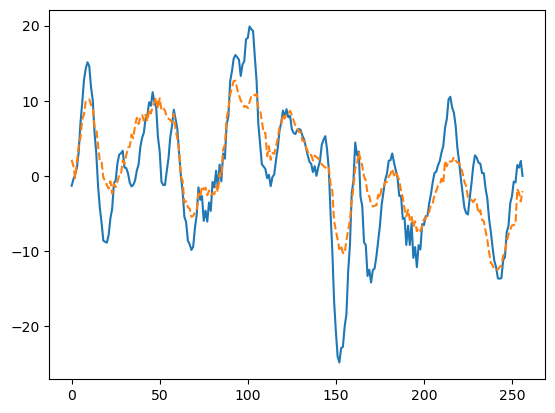

In [ ]:
plt.plot(B[..., 5, 2][100, :])
plt.plot(b[..., 5, 2][100, :], '--')